In [16]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow import convert_to_tensor, float32
# import torch
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [17]:
path = "Dataset/mitbih_database"
filenames = next(os.walk(path))[2]
records=list()
annotations=list()
filenames.sort()
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    if(file_extension=='.csv'):
        records.append(path+'/'+filename+file_extension)
    else:
        annotations.append(path+'/'+filename+file_extension)

In [18]:
def get_record_signals(index):
    signals = []
    labels = []
    with open(records[index],'r') as csvfile:
        filereader = csv.reader(csvfile,delimiter=',',quotechar='|')
        row_index = -1
        for row in filereader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
        signals = np.array(signals)
    with open(annotations[index],'r') as csvfile:
        filereader = csv.reader(csvfile,delimiter=',',quotechar='|')
        row_index = -1
        for row in filereader:
            if(row_index >= 0):
                elements = list(filter(lambda x: len(x) > 0, row[0].split(" ")))
                labels.insert(row_index, [int(elements[1]), elements[2]])
            row_index += 1
        labels = np.array(labels)
    return signals, labels

In [19]:
signals, labels = get_record_signals(6)
print("Number of samples:", len(signals))
print("Value Range:", np.min(signals), "->", np.max(signals))
print("Classes:", np.unique(labels[:, 1]))

Number of samples: 650000
Value Range: 611 -> 1538
Classes: ['+' 'N' 'V' '~']


In [20]:
def process_data(window_size):
    X = []
    y = []

    half_w = window_size // 2
    valid_labels = {'A', 'L', 'N', 'R', 'V'}

    for i in range(len(records)):
        signals, labels = get_record_signals(i)
        sig_len = len(signals)

        mask = np.isin(labels[:, 1], list(valid_labels))
        filtered_labels = labels[mask]

        for label in filtered_labels:
            center = int(label[0])
            start = center - half_w
            end = center + half_w

            if start < 0 or end > sig_len:
                continue

            X.append(signals[start:end])
            y.append(label[1])

    return X, y


In [21]:
X, y = process_data(window_size=200)

In [22]:
print("Total samples:", len(X))

Total samples: 100033


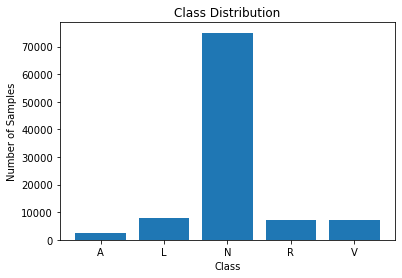

In [23]:
values, counts = np.unique(y, return_counts=True)
plt.bar(values, counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

In [24]:
# Train/test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
#Label Binarization
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [26]:
# Under-sampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto')

X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

In [27]:
#Min/Max Scaling

scaler = MinMaxScaler()

X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

In [28]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print(f"Using device: {device}")

In [29]:
print(type(X_test))
print(X_test.dtype)
print(X_test.shape)
print(type(X_test[0]))

<class 'numpy.ndarray'>
float64
(25009, 200)
<class 'numpy.ndarray'>


In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(200,), name="InputLayer"))
model.add(Dense(units=32, activation="relu", name=f"HiddenLayer-1"))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(X_train_res, y_train_res,
          epochs=20,
          batch_size=128)


Epoch 1/20


/home/laptop/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2468 - loss: 1.5950
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3273 - loss: 1.5350
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4055 - loss: 1.4657
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4517 - loss: 1.3785
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5104 - loss: 1.2944
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5529 - loss: 1.2274
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5702 - loss: 1.1712
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6092 - loss: 1.1099
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6427 - loss: 1.0560
Epoch 10/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6638 - loss: 1.0135
Epoch 11/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6647 - loss: 0.9850
Epoch 12/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6805 - loss: 0.9458


[0.8539811372756958, 0.6877924203872681]

In [33]:
X_test_tf = convert_to_tensor(X_test, dtype=float32)
y_test_tf = convert_to_tensor(y_test)

from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_matrix(y_true, y_pred)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[  448,    35,    95,    34,     0],
       [   45,  1908,    13,     1,    66],
       [ 4334,  2582, 11787,    80,    18],
       [  129,    49,     4,  1594,     1],
       [   62,   180,    24,    56,  1464]])

In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.09      0.73      0.16       612
           1       0.40      0.94      0.56      2033
           2       0.99      0.63      0.77     18801
           3       0.90      0.90      0.90      1777
           4       0.95      0.82      0.88      1786

    accuracy                           0.69     25009
   macro avg       0.67      0.80      0.65     25009
weighted avg       0.91      0.69      0.75     25009

